# LSTM MODEL

In [4]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


## LOAD PACKAGES AND MODULES

In [19]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
import os
import sys

original_sys_path = sys.path.copy()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../general_utils'))
sys.path.append(parent_dir)
from preprocessing import *
from metrics_plot_utils import *
sys.path = original_sys_path

## IMPORT T5 DATASET

In [21]:
# load dataset
df_train = pd.read_csv('C:/Users/Usuario/emotion-detection-txa/Pretrained_Model Implementation/t5_model_final.csv')

## DATA PREPROCESSING
First, we apply a preprocessing (correction of contractions, lowercase of all text, removal of non-alphanumeric characters) to the dataset.

Second, we tokenize and pad the training text using TensorFlow Keras TextVectorization.

Finally, we encode the labels of the dataset

In [22]:
#Preprocess training data
df_train['text'].apply(preprocess).to_frame()

# Tokenize and pad training data
padded_sequences, train_vocabulary, vocab_size = tokenize_and_pad(df_train[['text']])

# Set training data
train_data = padded_sequences

#Encoding labels for keras
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_train['predicted_label'])
num_classes = len(set(y_encoded))
y_encoded_cat = to_categorical(y_encoded, num_classes=num_classes)

## TRAIN-TEST SPLIT
We proceed to split the data into training and testing 

In [23]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(train_data, y_encoded_cat, test_size=0.2, random_state=42)

## HYPERPARAMETER OPTIMIZATION
A random search is performed on the training set to find the parameters that optimize the performance metrics of the model. 

In [14]:
# define model function
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Choice('output_dim', [64, 128, 256])))
    model.add(LSTM(hp.Int('lstm_units1', min_value=64, max_value=256, step=64), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(hp.Int('lstm_units2', min_value=32, max_value=128, step=32)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# set random search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,  
    executions_per_trial=2,  
    directory='tuner_results',
    project_name='emotion_classification'
)

# Execute search
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64)


Reloading Tuner from tuner_results\emotion_classification\tuner0.json


In [17]:
# Show best parameters
best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]
print("Best hyperparameters:", best_hps.values)

Best hyperparameters: {'output_dim': 256, 'lstm_units1': 256, 'dropout_rate': 0.30000000000000004, 'lstm_units2': 64}


## RUN MODEL WITH OPTIMIZED HYPERPARAMETERS IN TRAINING SET
Once the Random search results are obtained, the LSTM model is run with the obtained hyperparameters. An early stopping condition is added to avoid overfitting. 

In [ ]:
# set EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True  
)


# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=256))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))     
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))  # Use 'softmax' for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 1582s 1s/step - accuracy: 0.4281 - loss: 1.3316 - val_accuracy: 0.4319 - val_loss: 1.3268
Epoch 2/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 766s 556ms/step - accuracy: 0.5055 - loss: 1.2146 - val_accuracy: 0.6846 - val_loss: 0.8431
Epoch 3/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 730s 530ms/step - accuracy: 0.7278 - loss: 0.7520 - val_accuracy: 0.7666 - val_loss: 0.6439
Epoch 4/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 731s 531ms/step - accuracy: 0.8237 - loss: 0.4996 - val_accuracy: 0.7742 - val_loss: 0.5903
Epoch 5/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 730s 530ms/step - accuracy: 0.8771 - loss: 0.3484 - val_accuracy: 0.7740 - val_loss: 0.6463
Epoch 6/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 735s 525ms/step - accuracy: 0.9096 - loss: 0.2607 - val_accuracy: 0.7751 - val_loss: 0.6661
Epoch 7/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 726s 527ms/step - accuracy: 0.9348 - loss: 0.1900 - val_accuracy: 0.7679 - val_loss: 0.7679


## EVALUATE MODEL ON TEST DATA
From the model results, the performance of the model on the test set is evaluated.

In [31]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_1d = np.argmax(y_test, axis=1)
y_test_1d

765/765 ━━━━━━━━━━━━━━━━━━━━ 80s 105ms/step - accuracy: 0.7725 - loss: 0.6058
Test Accuracy: 0.7746
765/765 ━━━━━━━━━━━━━━━━━━━━ 78s 102ms/step


array([0, 1, 0, ..., 0, 1, 2], dtype=int64)

In [ ]:
predictions_probabilities = model.predict(X_test)
predicted_classes = label_encoder.inverse_transform(np.argmax(predictions_probabilities, axis=1))
true_classes = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
train_classes = label_encoder.inverse_transform(np.argmax(y_train, axis=1))

765/765 ━━━━━━━━━━━━━━━━━━━━ 103s 134ms/step


## COMPUTE RESULTS

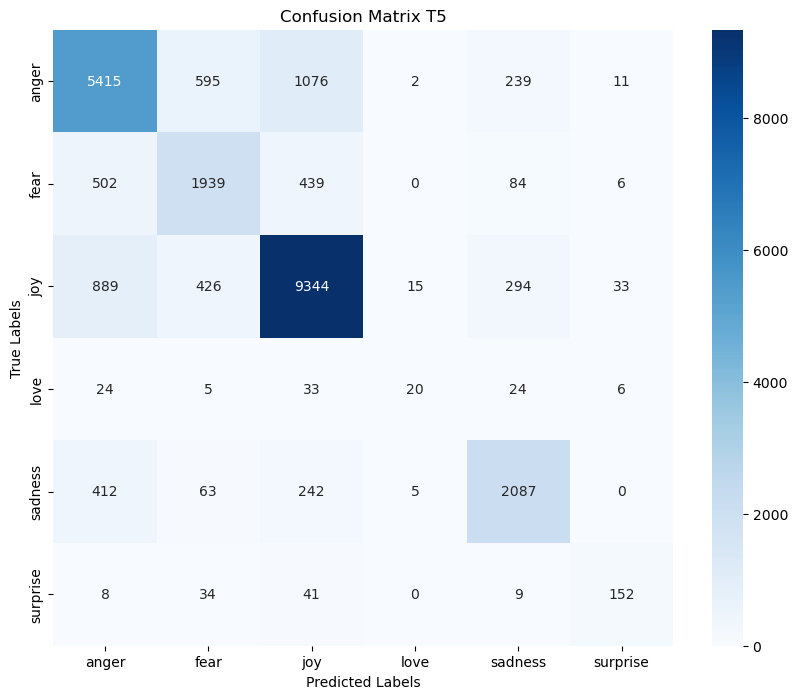

In [30]:
# Plot confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, label_encoder.classes_, "T5")

In [34]:
# Compute metrics
metrics = compute_metrics(predicted_classes, true_classes, f'results/LSTM/metrics_lstm_t5.txt')

Metrics Dictionary saved to results/LSTM/metrics_lstm_t5.txt


In [33]:
print(classification_report(predicted_classes, true_classes))

              precision    recall  f1-score   support

       anger       0.74      0.75      0.74      7250
        fear       0.65      0.63      0.64      3062
         joy       0.85      0.84      0.84     11175
        love       0.18      0.48      0.26        42
     sadness       0.74      0.76      0.75      2737
    surprise       0.62      0.73      0.67       208

    accuracy                           0.77     24474
   macro avg       0.63      0.70      0.65     24474
weighted avg       0.78      0.77      0.78     24474



In [36]:
# Save the model in HDF5 format

model.save('models/model_lstm_T5.h5') 